In [ ]:
# THE CONSUMER PRICE INDEX (CPI) IS A MEASURE OF THE AVERAGE CHANGE OVER TIME IN THE PRICES PAID BY URBAN CONSUMERS FOR A MARKET BASKET OF CONSUMER GOODS AND SERVICES.
# IN THIS CPI SERIES INDEX WE ARE LOOKING AT HOSPITAL SERVICES OVER THE PAST 10 YEAR PERIOD - INCREASE CPI = INFLATION = RISING COST OF LIVING
# TIME SERIES FORECASTING WITH ARIMA MODELING IS STATISTICAL AND PREDICTIVE APPROACH OF SEEING THE FUTURE BASED ON HISTORICAL DATA

In [1]:
#ALL THE PACKAGES I HAVE CAME ACROSS WHICH CAN DO MANY DIFFERET WAYS OF VIZUALIZATION IN PYTHON

import requests
import json
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
# SECTION OF CODE WHERE I CONNECT TO THE BLS.GOV API FOR CPI DATA
BLS_API_KEY = 'f25896f3a6d24c739dff89912a87b169'

headers = {'Content-type': 'application/json'}
data = {
    "seriesid": ["CUUR0000SEMD01"],
    "startyear": "2014",
    "endyear": "2025",
    "registrationkey": BLS_API_KEY
}


response = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', json=data, headers=headers)
json_data = response.json()

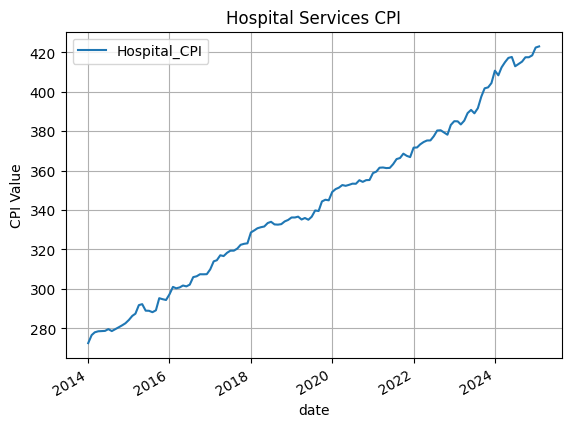

In [3]:
# THERE ARE MULTIPLE WAYS OF SAVING THE VARIOUS FIELDS FROM THE API. A SIMPLE LINE CHART OF HOSPITAL SERVICES CPI (NOT-SEASONALLY ADJUSTED).

series_data = json_data['Results']['series'][0]['data']
df = pd.DataFrame(series_data)
df['value'] = df['value'].astype(float)
df['date'] = pd.to_datetime(df['year'] + '-' + df['period'].str[1:] + '-01')
df = df[['date', 'value']].sort_values('date').reset_index(drop=True)
df.set_index('date', inplace=True)
df.rename(columns={'value': 'Hospital_CPI'}, inplace=True)

# Plot
df.plot(title='Hospital Services CPI')
plt.ylabel('CPI Value')
plt.grid(True)
plt.show()

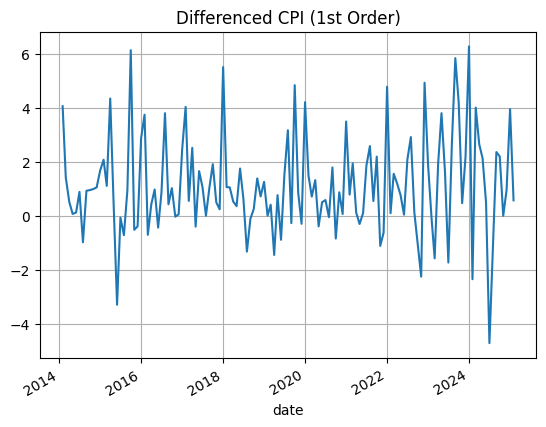

In [4]:
# THE FIRST DIFFERENCING - WHAT I AM LOOKING FOR IS A FLAT MEAN AND VARIANCE OVER TIME. NO CLEAR TRENDS OR SEASONALITY.
# No Trend: The data fluctuates around a relatively constant mean.
# Constant Variance: The ups and downs should be roughly the same size over time.
# Random Noise Appearance: It looks more like a flat, unpredictable series — no obvious patterns.
# ADF Test p-value < 0.05: Statistically confirms stationarity.
# IF FINANCIAL DATA, RULE OF THUMB IS THAT THE DATA ALWAYS NEEDS TO BE DIFFERENCED AT LEAST ONCE. CPI IS THAT.

ts = df['Hospital_CPI']
ts_diff = ts.diff().dropna()

ts_diff.plot(title='Differenced CPI (1st Order)')
plt.grid(True)
plt.show()

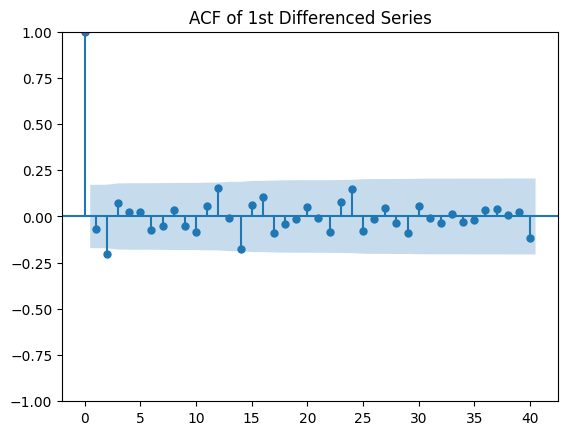

In [5]:
#ACF PLOT AFTER THE 1ST DIFFERENCED SERIES
plot_acf(ts_diff, lags=40)
plt.title("ACF of 1st Differenced Series")
plt.show()

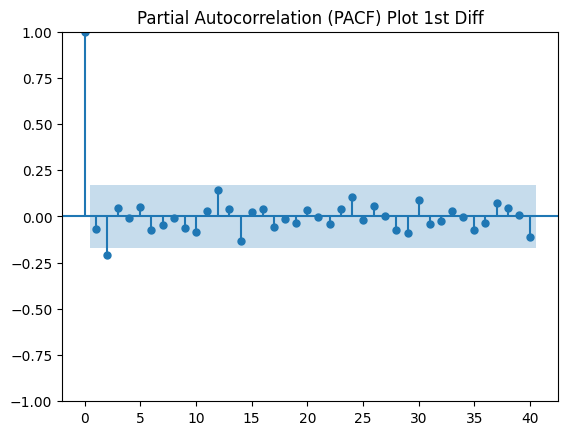

In [6]:
# PACF PLOT AFTER THE 1ST DIFFERENCED SERIES
plot_pacf(ts_diff, lags=40, method='ywm')
plt.title("Partial Autocorrelation (PACF) Plot 1st Diff")
plt.show()

In [7]:
# ADF TEST OUTPUT
# P-VALUE >0.05 - FAIL TO REJECT NULL -> TIME SERIES IS NON STATIONARY
# P-VALUE <= 0.05 - REJECT NULL -> TIME SERIES IS STATIONARY

result = adfuller(ts_diff)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -10.226538796662382
p-value: 5.159199498595934e-18


In [8]:
model = ARIMA(ts, order=(1, 1, 1))
model_fit = model.fit()

In [9]:
forecast_1_result = model_fit.get_forecast(steps=12)
forecast_1 = forecast_1_result.predicted_mean
conf_int = forecast_1_result.conf_int()
residuals = model_fit.resid

In [ ]:
# Ljung-Box Q Test
# A p-value greater than 0.05 (or 5%) suggests the residuals are random and independent, indicating the model is a good fit

In [10]:
# Perform Ljung-Box test (default lag is 10)
ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
10  0.040629        1.0


In [ ]:
# lb_pvalue -> P-value → the most important part
# If p-value > 0.05 → residuals do NOT show autocorrelation → model looks good!
# If p-value < 0.05 → residuals still have autocorrelation → model may be missing something.

In [11]:
ljung_box_results = acorr_ljungbox(residuals, lags=range(1, 21), return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
1   0.025883   0.872186
2   0.025957   0.987105
3   0.026918   0.998835
4   0.029466   0.999893
5   0.031256   0.999991
6   0.031405   0.999999
7   0.040531   1.000000
8   0.040531   1.000000
9   0.040568   1.000000
10  0.040629   1.000000
11  0.040648   1.000000
12  0.041982   1.000000
13  0.043680   1.000000
14  0.044006   1.000000
15  0.064735   1.000000
16  0.066018   1.000000
17  0.114518   1.000000
18  0.118293   1.000000
19  0.126247   1.000000
20  0.126270   1.000000


In [12]:
last_date = ts.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')
forecast_1.index = forecast_index
conf_int.index = forecast_index

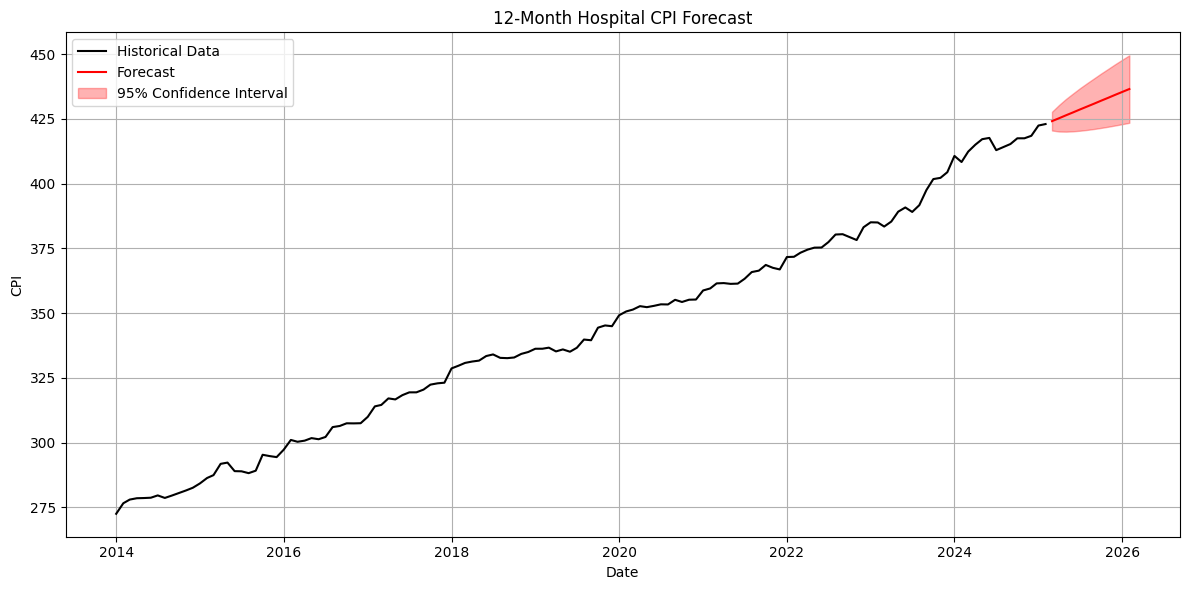

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Historical Data', color='black')
plt.plot(forecast_1, label='Forecast', color='red')
plt.fill_between(forecast_1.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='red', alpha=0.3, label='95% Confidence Interval')
plt.title('12-Month Hospital CPI Forecast')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
print("Forecast with 1st Differencing:")
print(forecast_1)

Forecast with 1st Differencing:
2025-03-01    424.132040
2025-04-01    425.259078
2025-05-01    426.386114
2025-06-01    427.513148
2025-07-01    428.640180
2025-08-01    429.767211
2025-09-01    430.894239
2025-10-01    432.021266
2025-11-01    433.148291
2025-12-01    434.275314
2026-01-01    435.402335
2026-02-01    436.529355
Freq: MS, Name: predicted_mean, dtype: float64


In [15]:
forecast_df = pd.DataFrame({
    'Forecast': forecast_1,
    'Lower CI (95%)': conf_int.iloc[:, 0],
    'Upper CI (95%)': conf_int.iloc[:, 1]
})



In [16]:
print(forecast_df)

              Forecast  Lower CI (95%)  Upper CI (95%)
2025-03-01  424.132040      420.513232      427.750847
2025-04-01  425.259078      420.122198      430.395957
2025-05-01  426.386114      420.071423      432.700804
2025-06-01  427.513148      420.194736      434.831560
2025-07-01  428.640180      420.428050      436.852310
2025-08-01  429.767211      420.738638      438.795784
2025-09-01  430.894239      421.107139      440.681339
2025-10-01  432.021266      421.520994      442.521538
2025-11-01  433.148291      421.971516      444.325066
2025-12-01  434.275314      422.452407      446.098222
2026-01-01  435.402335      422.958933      447.845738
2026-02-01  436.529355      423.487435      449.571275


In [ ]:
# MY CONCLUSION AFTER DOING THE FIRST DIFFERENCING. HOSPITAL SERVICES BASED ON CPI
# IS PRETTY STABLE ON ANNUAL AND MONTHLY TIME SERIES
# THE ACF AND PACF PLOTS LOOK WITHIN RANGE, AND THE ADF AND LJUNG-BOX TEST LOOK GREAT
# NO NEED TO CONTINUE DIFFERENCING THE DATA AS IT IS STATIONARY IN THIS MODEL